# Dependencies

- For easy use acitive the virutual enviroment: **MoonbouceEnviroment** 

In [99]:
from astropy.coordinates import SkyCoord, EarthLocation, Angle, Latitude, Longitude, get_moon
from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import numpy as np
import sqlite3

# Notebook Overview

Given a specific observation time a corresponding area on earth is able to emmit signals that can bounce off the moon and be collected at our reciever (GBT) which is locate in West Virginia. The created program takes in an obervation time and outputs an area that the possible collected signal could have originated from.

In [100]:
#Coordinates of Green Bank Telescope (Telescope used in Observation)
GBT = EarthLocation.of_site('GBT')
print(GBT)

(882598.25131862, -4924862.65979072, 3943712.65334219) m


# Generate A Time Range Array for Given Observation

In [101]:
#Create an Observation Time Range
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
        
def observation_timerange(start_year, start_month, start_day, start_hour, end_year, end_month, end_day, end_hour):
    #Time Range Year, Month, Day, Hour, Min
    dts = [dt.strftime('%Y-%m-%dT%H:%M') for dt in datetime_range(datetime(start_year, start_month, start_day, start_hour, 0), datetime(end_year, end_month, end_day, end_hour, 0), timedelta(minutes=60))]
    #Get Julian Days for Zenith Conversion Below
    JulianDays = []
    for i in dts:
        dt = datetime.strptime(i, '%Y-%m-%dT%H:%M')
        con = sqlite3.connect(":memory:")
        JulianDays = np.append(JulianDays, list(con.execute("select julianday('" +i[:-6]+ "')"))[0][0])
    return dts, JulianDays

**Input Given Observation Time Range Below**
- DTS represents an array of observation time
- JulianDays represent the dts array converted to julian day

In [102]:
DTS, JulianDays = observation_timerange(2008, 8, 30, 18, 2008, 8, 30, 19)
DTS

['2008-08-30T18:00']

# Generate Moon Position For Each Element In Time Range

In [103]:
#Example of Moon Position Over a Timerange 
mooncord = get_moon(Time(DTS, format='isot', scale='utc'), GBT)

In [104]:
#Example of a SkyCoord for a Specific Time, 
mooncord[0]

<SkyCoord (GCRS: obstime=['2008-08-30T18:00:00.000'], obsgeoloc=[(-4913596.35344491, 925429.63417863, 3947945.320131)] m, obsgeovel=[(-67.4734871, -358.5541934, 0.07070786)] m / s): (ra, dec, distance) in (deg, deg, km)
    (157.54001287, 7.07773149, 372238.57238027)>

In [105]:
#Get Right Ascention or Declinnation by going coord.ra or coord.dec
mooncord[0].ra

<Longitude 157.54001287 deg>

# Approach to Calculating Moon Sub-Point

Given a date and time, the position of the Moon can be calculated to provide the declination and right ascension. The sub-point of the Moon (the point on the Earth at which the Moon is at the zenith) is as follows:

- latitude = declination of the Moon

- longitude can be found by calculating the local mean sidereal time (LMST) that equals the Moon's right ascension. (LMST dependents on the date, time, and longitude.) Everything is known except for the longitude.

## Method (using GMST)

- Calculate the Local Mean Sidereal Time (LMST) where GMST is the Greenwich Mean Sidereal Time and 𝑙𝑜𝑛𝑔𝑒𝑎𝑠𝑡 is the longitude with positive values in the eastern hemisphere

   **𝐿𝑀𝑆𝑇=𝐺𝑀𝑆𝑇+𝑙𝑜𝑛𝑔𝑒𝑎𝑠𝑡**
   

- The Astronomical Almanac gives an expression for approximate mean sidereal time, in hours: 

    GMST=6.697374558+0.06570982441908 𝐷 +1.00273790935 𝐻 +0.000026 𝑇^2
    

- Where GMST is the mean sidereal time in hours, 𝐻 is the universal time at the time in question, 𝐷0 is the Julian date on the previous midnight of the time in question less 2451545.0, 𝐷 is the Julian date at the time in question (including fractional days) less 2451545.0, and 𝑇 is 𝐷/36525. The relationship between 𝐷0 is quite simple: 𝐷0=𝐷−𝐻/24. Substituting this in the above and omitting the quadratic term yields

    GMST=6.697374558+0.06570982441908(𝐷0−𝐻/24)+1.00273790935𝐻
    
        =6.697374558+0.06570982441908𝐷+𝐻
    
- Multiplying by 15 yields the GMST in degrees:

    **GMST_deg=100.4606184+0.9856473662862𝐷+15𝐻**
 





In [106]:
#Generate Lat, Long Sub-Point Based on the Method Described Above of all Observation Times
def moonSubPoint(mooncord):
    lat, long, JD = [], [], 2451545
    for i in range(len(mooncord)):
        Time = DTS[i]
        lat = np.append(lat, float(str(mooncord[i].dec*u.degree)[:-5]))
        LMST = float(str(mooncord[i].ra*u.degree)[:-4])%360
        D = JulianDays[i] - JD
        GMST = (100.4606184 + 0.9856473662862 * D + 15*int(Time[11:13]))%360
        print(Time, "LMST:", LMST, "GMST:", GMST)
        temp = LMST - GMST 
        if temp < -180:
            temp = 360 + temp
        elif temp > 180:
            temp = temp - 360
        long = np.append(long, temp)
    return lat, long 

In [107]:
lat, long = moonSubPoint(mooncord)

2008-08-30T18:00 LMST: 157.540012874841 GMST: 248.55606164639357


# Graphing Moon Sub-Point

In [108]:
data = {'longitude': long,'latitude': lat, 'Observation Time UTC': DTS, 'Type': []}
df = pd.DataFrame(data, columns = ['longitude','latitude', 'Observation Time UTC'])
calculations = df

In [109]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
gdf

,longitude,latitude,Observation Time UTC,geometry
0,-91.016049,7.077731,2008-08-30T18:00,POINT (-91.01605 7.07773)


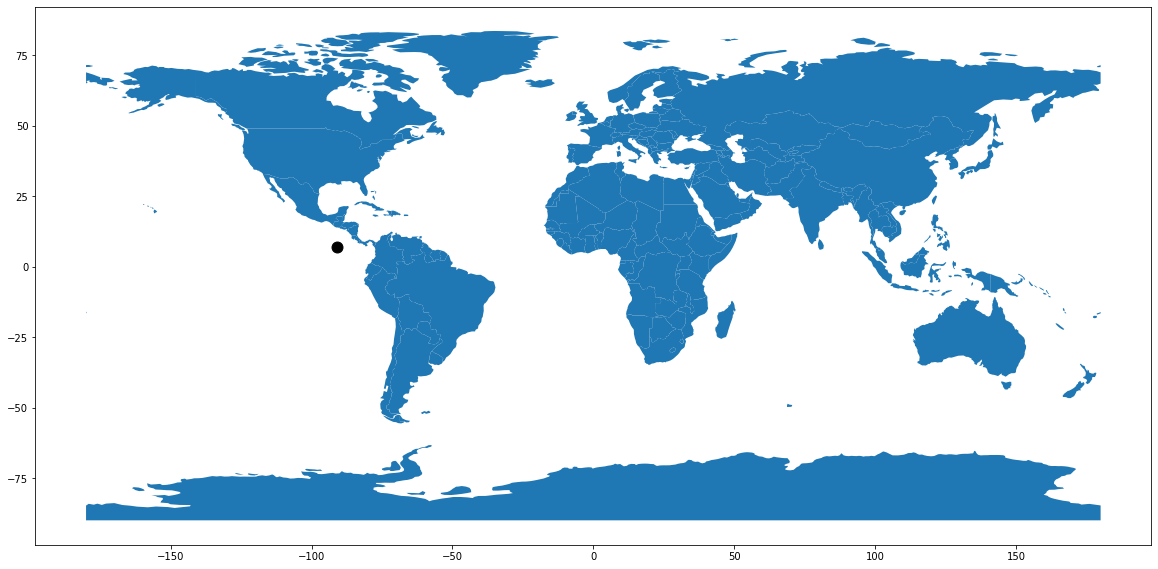

In [110]:
#Shows Moon Subpoint 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 12)), marker='o', color='black', markersize=120);

# Generate A Corresponding Region of Potential Signals

### ObservationEdge and Haversine Function

 ### Haversine
 
 - This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, the shortest distance over the earth’s surface. This function disregards terrain/elevation affecting distance.
 
 - Formula where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km)
 
      a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
      
      c = 2 ⋅ atan2( √a, √(1−a) )
      
      d = R ⋅ c
      
### ObservationEdge
  
- Takes in a dataframe as seen in the Moon Sub-Point section and return an array of lat, long pairs the represent the moon terminator line, or the edge of the area on earth that is visible from the moon.

In [ ]:
def Haversine(lat1,lon1,lat2,lon2):
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

def observationEdge(df):
    pointslat = []
    pointslong = []
    for index, row in df.iterrows():
        long1 = row['longitude']
        lat1 = row['latitude']
        for lat2 in np.arange(-90, 90, .2):
            for long2 in np.arange(-180, 180, .2):
                distance = Haversine(lat1,long1,lat2,long2)
                if  (distance > (40075//4) - 20) and (distance < (40075//4) + 20):
                    pointslat = pointslat + [lat2]
                    pointslong = pointslong + [long2]                               
    return pointslat, pointslong


latitude, longitude = observationEdge(df)
#Example of Lat/Long Output for observationEdge function
latitude[0], longitude[0]

## Example Graph of Teminator Line Based on  Moon Sub-Point Input

In [ ]:
terminator = [Point(xy) for xy in zip(longitude, latitude)]
df['Observation Border Point'] = [terminator]
gdf1 = GeoDataFrame(geometry=terminator)  

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf1.plot(ax=world.plot(figsize=(40, 24)), marker='o', color='red', markersize=.1);

# Tranmitters

## Clean Transmitter Data Convert DDMMSS -> Degrees

In [ ]:
transmitters = pd.read_excel('DTV-Channels US.xlsx', index_col=None, header=None) 
transmitters = transmitters.rename(columns=transmitters.iloc[0])
transmitters = transmitters.iloc[1:]
transmitters
#Latitude in DDMMSS, Longitude in DDDMMSS 

In [ ]:
# Convert DDMMSS/DDDMMSS To Degrees Given A Pandas df As Input
def ddmmss_deg(df):
    for index, row in df.iterrows():
        lat = str(row['Latitude'])
        long = str(row['Longitude'])
        row['Latitude'] = float(lat[:2]) + float(lat[2:4])/60 + float(lat[4:6])/(60*60)
        if len(long) == 6:
            temp = float(long[:2]) + float(long[2:4])/60 + float(long[4:6])/(60*60)
            if temp + 180 > 180 :
                row['Longitude'] = -180 + abs(temp - 180)
            else:
                row['Longitude'] = temp
        else:
            temp = float(long[:3]) + float(long[3:5])/60 + float(long[5:7])/(60*60)
            if temp + 180 > 180:
                row['Longitude'] = -180 + abs(temp -  180)
            else:
                row['Longitude'] = temp
    return df

## Plot Known US Transmitters

In [ ]:
transmitters = ddmmss_deg(transmitters)

In [ ]:
geometry = [Point(xy) for xy in zip(transmitters['Longitude'], transmitters['Latitude'])]
gdftransmitters = GeoDataFrame(transmitters, geometry=geometry)   

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdftransmitters.plot(ax=world.plot(figsize=(30, 18)), marker='o', color='red', markersize=.5);

## More Global Transmitter Data
-  Source: https://www.nautel.com/about/nautel-radio-transmitter-world-map/

In [ ]:
trans = pd.read_json('transmitters.json')
trans.iloc[0]

-  Transmitter JSON or File must have columns name longitude or latitude to run below script.

In [ ]:
geometry = [Point(xy) for xy in zip(trans['longitude'], trans['latitude'])]
gdftransmitters = GeoDataFrame(trans, geometry=geometry)  
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdftransmitters.plot(ax=world.plot(figsize=(40, 24)), marker='o', color='red', markersize=5);

In [ ]:
#Distinguishes Bewteen Transmitter Locations For Different Countries
#Set lengend = True to show country color key
gdftransmitters.plot(column='country', ax=world.plot(figsize=(30, 18)), legend=False, markersize=5)

#  Filter Transmitters

- In this section known transmitter are filtered based on a variety of factors including distance from the terminator, frequency, power.

In [ ]:
def filtertranmitters(terminator_df, trans_df, term_distance, frequency_range):
    for index, row in terminator_df.iterrows():
        long1 = row['longitude']
        lat1 = row['latitude']
        rows_drop = []
        for i, r in trans_df.iterrows():
            long2 = r['longitude']
            lat2 = r['latitude']
            distance = Haversine(lat1,long1,lat2,long2)
            if  not((distance > (40075//4) - term_distance) and (distance < (40075//4) + term_distance)):
                rows_drop = rows_drop + [i]
    new_df = trans_df.drop(rows_drop, axis=0)         
    return new_df

In [ ]:
filteredtrans = filtertranmitters(df, trans, 280, 50)
df.to_csv('filteredtrans.csv')

In [ ]:
def diplay_tranmitters(filteredtrans):
    geometry = [Point(xy) for xy in zip(filteredtrans['longitude'], filteredtrans['latitude'])]
    gdftransmitters = GeoDataFrame(filteredtrans, geometry=geometry)  
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    temp = gdftransmitters.plot(ax=world.plot(figsize=(40, 24)), marker='o', color='red', markersize=10);
    temp = gdf1.plot(ax=temp, marker='o', color='red', markersize=1);
    gdf.plot(ax=temp, marker='o', color='red', markersize=2000);
    
diplay_tranmitters(filteredtrans)

In [ ]:
def diplay_tranmitters_power(filteredtrans):
    geometry = [Point(xy) for xy in zip(filteredtrans['longitude'], filteredtrans['latitude'])]
    gdftransmitters = GeoDataFrame(filteredtrans, geometry=geometry)  
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    temp = gdftransmitters.plot(ax=world.plot(figsize=(40, 24)), marker='o', color='red', markersize=filteredtrans.power);
    temp = gdf1.plot(ax=temp, marker='o', color='red', markersize=1);
    gdf.plot(ax=temp, marker='o', color='red', markersize=2000);
    
diplay_tranmitters_power(filteredtrans)
